# Classical geostatistics (geosclassic wrapper) - examples 3D with non-stationary covariance model

Examples of estimation and simulation for a continuous variable in a 3D grid, based on simple and ordinary kriging, and with a non-stationary covariance model are proposed.

**Remark:** for details explanations about estimation and simulation, see jupyter notebook `ex_geosclassic_3d.ipynb`.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

# import package 'geone'
import geone as gn

In [2]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

## Launching simulation and estimation in 3D
The following functions are used:
- `geone.geosclassicinterface.simulate3D` for simulation 3D (sequential Gaussian simulation, SGS),
- `geone.geosclassicinterface.estimate3D` for estimation 3D (kriging estimates and standard deviation).

See jupyter notebook `ex_geosclassic_3d.ipynb` for details.

## Simulation grid
The grid should be defined before defining the non-stationary covariance model.

In [3]:
nx, ny, nz = 85, 56, 34  # number of cells
dx, dy, dz = 1.0, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

dimension = (nx, ny, nz)
spacing = (dx, dy, dz)
origin = (ox, oy, oz)

## Define a non-stationary covariance model in 3D: class `geone.covModel.covModel3D`

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

Orientation is given by azimuth (`alpha`), dip (`beta`) and plunge (`gamma`) angles in degrees: the coordinates system Ox'''y''''z''', supporting the axes of the model (ranges), is obtained from the original coordinates system Oxyz as follows:
    - Oxyz       -> rotation of angle -alpha around Oz   -> Ox'y'z'
    - Ox'y'z'    -> rotation of angle -beta  around Ox'  -> Ox''y''z''
    - Ox''y''z'' -> rotation of angle -gamma around Oy'' -> Ox'''y'''z'''
    
The parameters of each elementary contribution and the angles `alpha`, `beta`, `gamma` can be set to a `numpy array` with values attached to the simulation grid. Hence, the size of the array and the number of grid cells must match (the array is reshaped if needed). In this way a non-stationary covariance model can be defined.

**Remark:** some functionalities such as getting the sill, range, or plotting the model are not available for non-stationary covariance model.

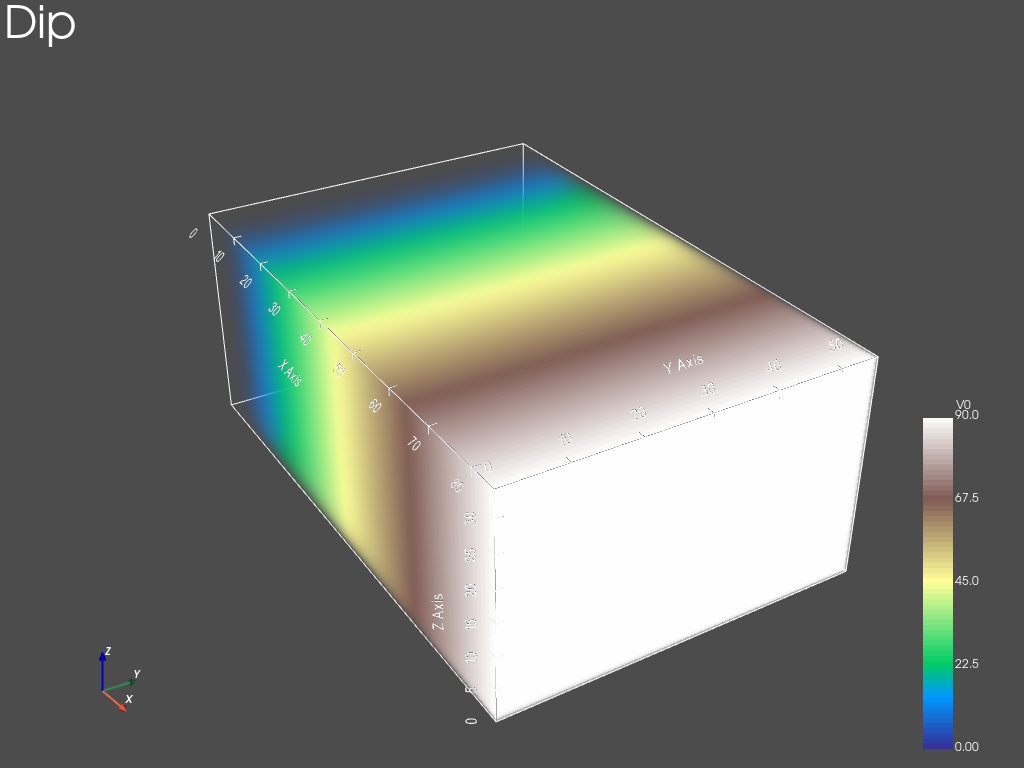

In [4]:
xgrid = ox + (np.arange(nx)+0.5)*dx # x coordinate along the x-axis of the sim. grid
ygrid = oy + (np.arange(ny)+0.5)*dy # y coordinate along the y-axis of the sim. grid
zgrid = oz + (np.arange(nz)+0.5)*dz # z coordinate along the z-axis of the sim. grid

# x, y, z coordinates of every sim. grid cell
zz, yy, xx = np.meshgrid(zgrid, ygrid, xgrid, indexing='ij')

# Define azimuth angle over the simulation grid
beta = 0 + (xx-xx.min())/(xx.max()-xx.min())*90.

im_beta = gn.img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=1, val=beta)

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

gn.imgplot3d.drawImage3D_volume(im_beta, plotter=pp,
                                text='Dip',
                                cmap='terrain',
                                show_bounds=True,
                                scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [5]:
# Define the non-stationary covariance model 
cov_model = gn.covModel.CovModel3D(elem=[
    ('spherical', {'w':8.9, 'r':[10, 40, 10]}), # elementary contribution
    ('nugget', {'w':0.1})                      # elementary contribution
    ], alpha=90, beta=beta, gamma=0, name='model-3D example')

### Conditional simulations (hard data) (function `geone.geosclassicinterface.simulate3D`)
Define hard data. Note that the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

In [6]:
x = np.array([[ 10.5,  20.5,  3.5], # 1st point
              [ 40.5,  10.5, 10.5], # 2nd point
              [ 30.5,  40.5, 20.5], # 3rd point
              [ 30.5,  30.5, 30.5]]) # 4th point
v = [ -3.,  2.,   5.,  -1.] # values

In [7]:
# Simulation
nreal = 50
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulate3D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging', nreal=nreal)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20210831 / OpenMP 7 thread(s)]
Geos-Classic run complete

Warnings encountered (11 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)


In [8]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

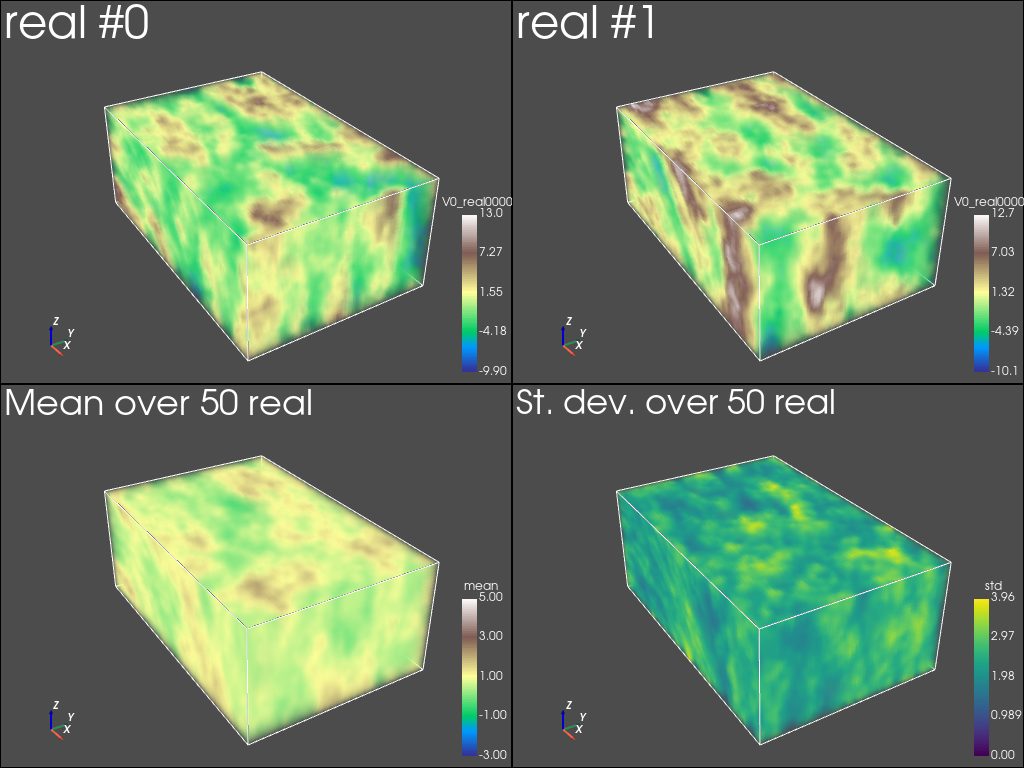

In [9]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_volume(simul, iv=i, plotter=pp,
                                    text='real #{}'.format(i),
                                    cmap='terrain',
                                    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
# mean of all real
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(simul_mean, plotter=pp,
                                text='Mean over {} real'.format(nreal),
                                cmap='terrain', 
                                scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(simul_std, plotter=pp,
                                text='St. dev. over {} real'.format(nreal),
                                cmap='viridis', 
                                scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

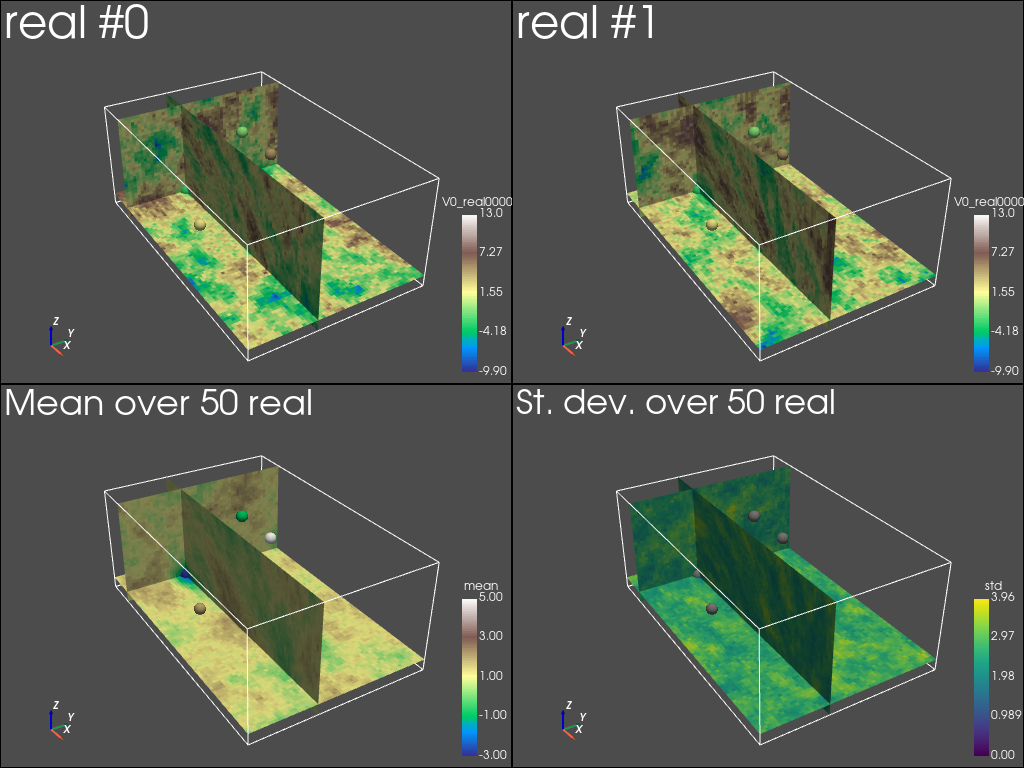

In [10]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
# data points to be added to 3D plot of real
data_points = pv.PolyData(x)
# ... set color for data points according to their value (plot of real)
cmap = plt.get_cmap('terrain') # color map
cmin = np.min(simul.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(simul.vmax()[0:1]) # max value for real 0 and 1
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col
# ... plot
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_slice(simul, iv=i, plotter=pp,
                                   slice_normal_x=x[0,0],
                                   slice_normal_y=x[0,1],
                                   slice_normal_z=x[0,2],
                                   text='real #{}'.format(i),
                                   cmap=cmap, cmin=cmin, cmax=cmax,
                                   scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

# mean of all real
# data_points_mean: to be added to 3D plot of mean
data_points_mean = pv.PolyData(x)
# ... set color for data points according to their value (plot of mean)
cmap = plt.get_cmap('terrain') # color map
cmin = simul_mean.vmin()[0] # min value for mean
cmax = simul_mean.vmax()[0] # max value for mean
data_points_mean_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points_mean['colors'] = data_points_mean_col
# ... plot
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(simul_mean, plotter=pp,
                               slice_normal_x=x[0,0],
                               slice_normal_y=x[0,1],
                               slice_normal_z=x[0,2],
                               text='Mean over {} real'.format(nreal),
                               cmap=cmap, cmin=cmin, cmax=cmax,
                               scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True)

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(simul_std, plotter=pp,
                               slice_normal_x=x[0,0],
                               slice_normal_y=x[0,1],
                               slice_normal_z=x[0,2],
                               text='St. dev. over {} real'.format(nreal),
                               cmap='viridis', 
                               scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Estimation: kriging estimates and standard deviation
#### Function `geone.geosclassicinterface.estimate3D`
*Note:* unique search neighorhood can not be used with a non-stationary covariance model.

Extract random points from the first realization to set conditioning data.

In [11]:
im = gn.img.Img(nx, ny, nz, dx, dy, dz, ox, oy, oz, nv=1, val=simul.val[0])
ps = gn.img.extractRandomPointFromImage(im, 140, seed=444)
new_x = ps.val[0:3].T # location of conditioning data
new_v = ps.val[3]     # value at conditioning data

In [12]:
# Increase searchRadiusRelative to avoid "discontinuities"
geosclassic_output = gn.geosclassicinterface.estimate3D(cov_model, dimension, spacing, origin, 
                                                        x=new_x, v=new_v, method='simple_kriging',
                                                        searchRadiusRelative=2.0)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20210831 / OpenMP 7 thread(s)]
Geos-Classic run complete

Warnings encountered (192 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)


In [13]:
# Retrieve the results of estimation
estim = geosclassic_output['image']

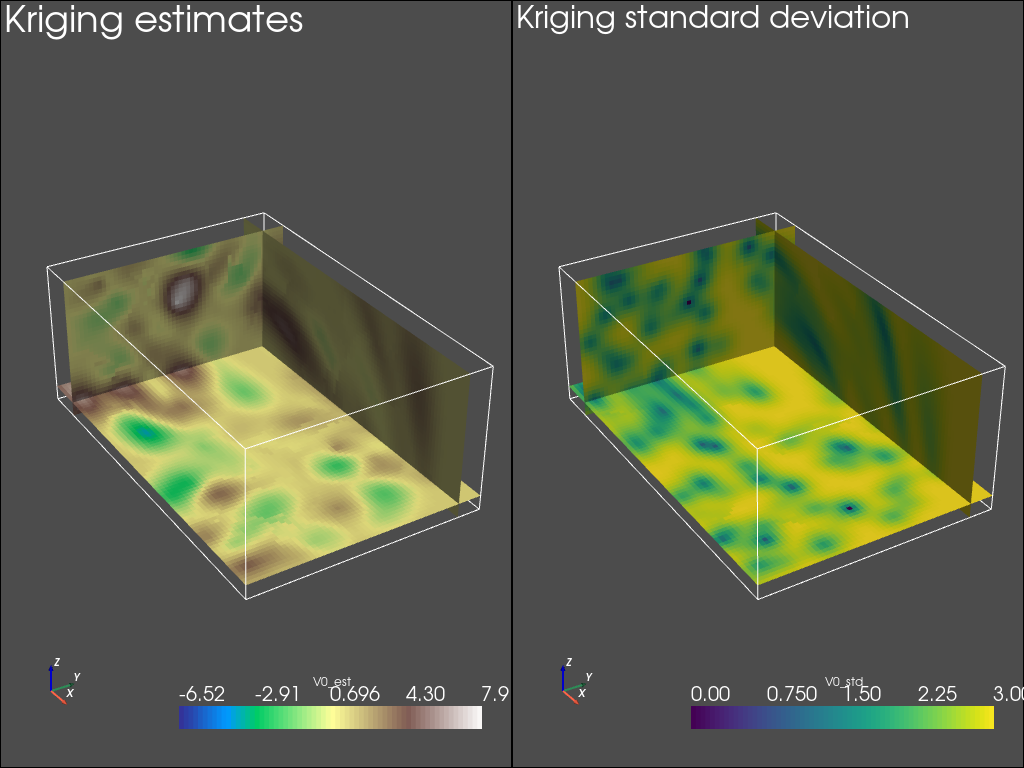

In [14]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))

# data points to be added to 3D plot
cmap = plt.get_cmap('terrain') # color map
cmin = estim.vmin()[0] # min value for krig. est.
cmax = estim.vmax()[0] # max value for krig. est.

# coordinate for othogonal slices
cx, cy, cz = im.ox+0.1*im.nx*im.sx, im.oy+0.9*im.ny*im.sy, im.oz+0.1*im.nz*im.sz # center of image
# kriging estimates
pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_slice(estim, iv=0, plotter=pp,
                               slice_normal_x=cx,
                               slice_normal_y=cy,
                               slice_normal_z=cz,
                               text='Kriging estimates',
                               cmap=cmap, cmin=cmin, cmax=cmax, 
                               scalar_bar_kwargs={'label_font_size':20})

# kriging standard deviation
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(estim, iv=1, plotter=pp,
                               slice_normal_x=cx,
                               slice_normal_y=cy,
                               slice_normal_z=cz,
                               text='Kriging standard deviation',
                               cmap='viridis', 
                               scalar_bar_kwargs={'label_font_size':20})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

## Conditioning with inequality data (simulation only)

Simulation can be done with usual hard data and inequality data consisting in a lower and/or upper bound at some points.

The conditioning locations with inequality data are first simulated (with truncated gaussian distribution) sequentially. Then, these locations are re-simulated following a new path as many times as desired (Gibbs sampler). The total number of path(s) is given by the keyword argument `nGibbsSamplerPath` (default: 50).

Define hard data and inequality data with minimal value and inequality with maximal value. Note that the conditioning values (hard, min. or max.) will be attached to the grid cells containing the corresponding conditioning locations.

In [15]:
# Hard data
x = np.array([[ 10.5,  20.5,  3.5], # 1st point
              [ 40.5,  10.5, 10.5], # 2nd point
              [ 30.5,  40.5, 20.5], # 3rd point
              [ 30.5,  30.5, 30.5]]) # 4th point
v = [ -3.,  2.,   5.,  -1.] # values

# Inequality data
xIneqMin = np.array([[ 10.5,  10.5,  6.5],   # 1st point
                     [ 50.5,  20.5, 20.5]])  # 2nd point
vIneqMin = [4., -2.2]  # lower bounds

xIneqMax = np.array([[ 65.5,   5.5,  3.5],   # 1st point
                     [ 50.5,  20.5, 20.5]])  # 2nd point
vIneqMax = [-4.1, -2.]  # upper bounds
# Note: second inequality data point has a lower bound and an upper bound

In [16]:
nreal = 50
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulate3D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, 
                                                        xIneqMin=xIneqMin, vIneqMin=vIneqMin,
                                                        xIneqMax=xIneqMax, vIneqMax=vIneqMax,
                                                        method='simple_kriging', nreal=nreal)

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20210831 / OpenMP 7 thread(s)]
Geos-Classic run complete

Warnings encountered (19 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)


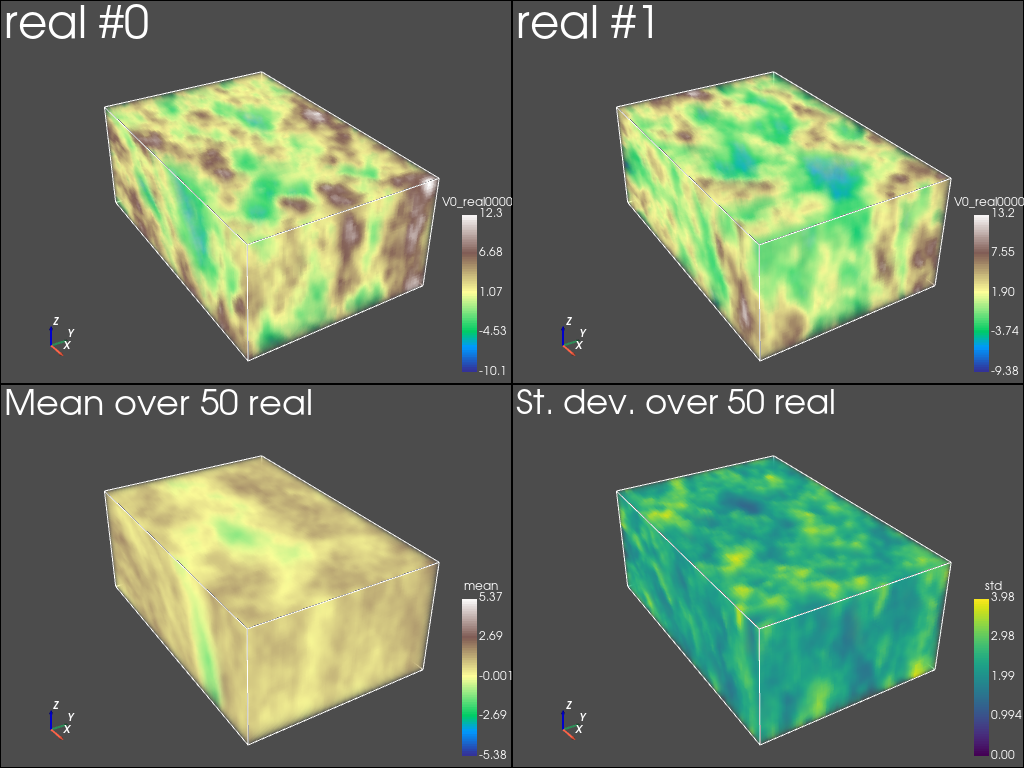

In [17]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_volume(simul, iv=i, plotter=pp,
                                    text='real #{}'.format(i),
                                    cmap='terrain',
                                    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
# mean of all real
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(simul_mean, plotter=pp,
                                text='Mean over {} real'.format(nreal),
                                cmap='terrain', 
                                scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(simul_std, plotter=pp,
                                text='St. dev. over {} real'.format(nreal),
                                cmap='viridis', 
                                scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

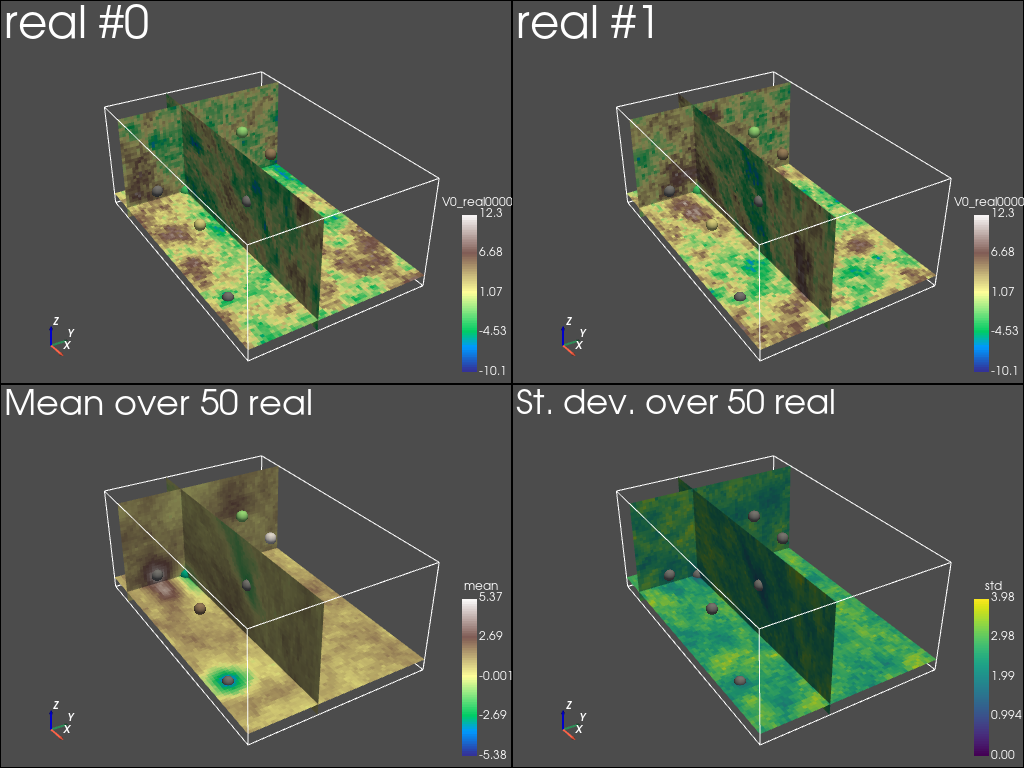

In [18]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

data_points_ineq_min = pv.PolyData(xIneqMin)
data_points_ineq_max = pv.PolyData(xIneqMax)

# 2 first reals
# data points to be added to 3D plot of real
data_points = pv.PolyData(x)
# ... set color for data points according to their value (plot of real)
cmap = plt.get_cmap('terrain') # color map
cmin = np.min(simul.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(simul.vmax()[0:1]) # max value for real 0 and 1
data_points_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points['colors'] = data_points_col
# ... plot
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_slice(simul, iv=i, plotter=pp,
                                   slice_normal_x=x[0,0],
                                   slice_normal_y=x[0,1],
                                   slice_normal_z=x[0,2],
                                   text='real #{}'.format(i),
                                   cmap=cmap, cmin=cmin, cmax=cmax,
                                   scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)
    pp.add_mesh(data_points_ineq_min, color='gray', point_size=12., render_points_as_spheres=True)
    pp.add_mesh(data_points_ineq_max, color='gray', point_size=12., render_points_as_spheres=True)

# mean of all real
# data_points_mean: to be added to 3D plot of mean
data_points_mean = pv.PolyData(x)
# ... set color for data points according to their value (plot of mean)
cmap = plt.get_cmap('terrain') # color map
cmin = simul_mean.vmin()[0] # min value for mean
cmax = simul_mean.vmax()[0] # max value for mean
data_points_mean_col = [cmap((vv-cmin)/(cmax-cmin)) for vv in v] # color for data points according to their value
data_points_mean['colors'] = data_points_mean_col
# ... plot
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(simul_mean, plotter=pp,
                               slice_normal_x=x[0,0],
                               slice_normal_y=x[0,1],
                               slice_normal_z=x[0,2],
                               text='Mean over {} real'.format(nreal),
                               cmap=cmap, cmin=cmin, cmax=cmax,
                               scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True)
pp.add_mesh(data_points_ineq_min, color='gray', point_size=12., render_points_as_spheres=True)
pp.add_mesh(data_points_ineq_max, color='gray', point_size=12., render_points_as_spheres=True)

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(simul_std, plotter=pp,
                               slice_normal_x=x[0,0],
                               slice_normal_y=x[0,1],
                               slice_normal_z=x[0,2],
                               text='St. dev. over {} real'.format(nreal),
                               cmap='viridis', 
                               scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)
pp.add_mesh(data_points_ineq_min, color='gray', point_size=12., render_points_as_spheres=True)
pp.add_mesh(data_points_ineq_max, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Check that conditioning data are honoured

In [19]:
# Compute min and max (pixel-wise)
simul_min = gn.img.imageContStat(simul, op='min')
simul_max = gn.img.imageContStat(simul, op='max')

# Get index of conditioning location in simulation grid
hd_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], dx, dy, dz, ox, oy, oz) for xx in x]
ineqMin_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], dx, dy, dz, ox, oy, oz) for xx in xIneqMin]
ineqMax_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], dx, dy, dz, ox, oy, oz) for xx in xIneqMax]

# Min and max value at hard data
min_value_at_hd = [simul_min.val[0][grid_index[::-1]] for grid_index in hd_grid_index]
max_value_at_hd = [simul_max.val[0][grid_index[::-1]] for grid_index in hd_grid_index]
print('Hard data value:\n{}'.format(v))
print('Min and max value at hard data:\n{}\n{}\n'.format(
    min_value_at_hd, max_value_at_hd))

# Min and max value at inequality data with minimal value
min_value_at_ineqMin = [simul_min.val[0][grid_index[::-1]] for grid_index in ineqMin_grid_index]
max_value_at_ineqMin = [simul_max.val[0][grid_index[::-1]] for grid_index in ineqMin_grid_index]
print('Minimal data value:\n{}'.format(vIneqMin))
print('Min and max value at inequality data with maximal value:\n{}\n{}\n'.format(
    min_value_at_ineqMin, max_value_at_ineqMin))

# Min and max value at inequality data with maximal value
min_value_at_ineqMax = [simul_min.val[0][grid_index[::-1]] for grid_index in ineqMax_grid_index]
max_value_at_ineqMax = [simul_max.val[0][grid_index[::-1]] for grid_index in ineqMax_grid_index]
print('Maximal data value:\n{}'.format(vIneqMax))
print('Min and max value at inequality data with maximal value:\n{}\n{}'.format(
    min_value_at_ineqMax, max_value_at_ineqMax))

Hard data value:
[-3.0, 2.0, 5.0, -1.0]
Min and max value at hard data:
[-3.0, 2.0, 5.0, -1.0]
[-3.0, 2.0, 5.0, -1.0]

Minimal data value:
[4.0, -2.2]
Min and max value at inequality data with maximal value:
[4.001464308511581, -2.19623639479763]
[9.607577458672, -2.0074422756265338]

Maximal data value:
[-4.1, -2.0]
Min and max value at inequality data with maximal value:
[-7.474754724826042, -2.19623639479763]
[-4.113105617031174, -2.0074422756265338]
